# <center>JBP031-B-6 Data-structures and algorithms 2023</center>
### <center>Garbage Collection Group Project </center>

#### Graph Class & Test function definition

In [24]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import timeit
import itertools

class Graph:
    """ Graph is composed of Adjacency matrix and the target number of bins.
    Two bins should not be placed adjacent to each other."""

    __slots__ = ["adjacency_matrix", "n", "m", "k"]

    def __init__(self, n, m, k) -> None:
        '''Initialise empty graph

        :param int n: Number of vertices
        :param int m: Number of edges
        :param int k: Target size of independent set
        '''
        self.n = n
        self.m = m
        self.k = k
        self.adjacency_matrix = [[False] * n for _ in range(n)]
    
    @classmethod
    def from_file(cls, file_path) -> None:
        '''Loads a graph from a file

        :param str file_path: Path to graph input file
        '''
        with open(file_path, 'r') as f:
            # extract graph parameters
            m, n, k = map(int, f.readline().split())
            # call graph class constructor
            graph = cls(n, m, k)
            # skip whitespaces
            edges = [line for line in f if not line.isspace()]
            for edge in edges:
                # extract vertices connected by edge 
                u, v = map(int, edge.split())
                graph.add_edge(u-1, v-1)
        return graph
    
    def add_edge(self, u, v) -> None:
        '''Adds an edge between vertex u and vertex v on the adjacency matrix

        :param int u: Vertex 1 index
        :param int v: Vertex 2 index
        '''
        self.adjacency_matrix[u][v] = True
        self.adjacency_matrix[v][u] = True
    
    def draw_graph(self, nodes_to_highlight = None) -> None:
        '''Draws the graph
        
        :param list nodes_to_highlight: List that represents nodes in independent set
        '''

        # Create graph from adjacency matrix
        G = nx.from_numpy_matrix(np.array(self.adjacency_matrix))

        # Set node position using the Fruchterman-Reingold layout
        pos = nx.spring_layout(G)

        # Draw the graph
        fig, ax = plt.subplots(figsize=(6, 4))

        # Remap nodes from matrix to match input names
        labels = {node: str(node + 1) for node in G.nodes()}

        # Draw vertices with circles
        nx.draw_networkx_nodes(G, pos=pos, node_size=0, ax=ax)
        nodes = nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=10, font_color='black', ax=ax)

        # Add Circle coloring
        for index, node_patch in nodes.items():
            node_patch.set_bbox(dict(boxstyle="circle,pad=0.3", fc="white", ec="black", lw=2))
            # If there is a given independent set
            if nodes_to_highlight:
                # Set title, if there is atleast one True in list
                result_title = "possible" if any(nodes_to_highlight) else "not possible"
                plt.title(result_title)
                # Color nodes
                if nodes_to_highlight[index]:
                    node_patch.set_bbox(dict(boxstyle="circle,pad=0.3", fc="yellow", ec="black", lw=2))

        # Draw edges
        nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color='black')

        # Show plot
        plt.show()

    def validate_and_show_bins(self, algorithm) -> None:
        '''Runs given algorithm and displays result graph
        
        :param function algorithm: Given algorithm that finds the independent set 
        '''
        print(f"Result via '{algorithm.__name__}':")
        result = algorithm(self)
        # Create independent set based on algorithm output
        independent_set = [] if result is None else result
        vertex_colors = [i in independent_set for i in range(self.n)]

        self.draw_graph(vertex_colors)

In [25]:
def test_algorithm(algorithm, exclude_long = False):
    '''Test algorithm against all given cases
    
    :param function algorithm: Algorithm you want to test
    :param boolean exclude_long: Exclude big_4 and big_5 tests
    '''
    directory = "samples/"

    def read_expected(file_path):
        with open(file_path, 'r') as f:
            first_line = f.readline().strip()
        return first_line

    file_paths = sorted([(os.path.join(directory, filename),
                   os.path.join(directory, filename[:-3] + ".out"))
                  for filename in os.listdir(directory)
                  if filename.endswith(".in")], reverse = True)

    if exclude_long:
        file_paths = [path for path in file_paths if path not in [("samples/big_4.in", "samples/big_4.out"), ("samples/big_6.in", "samples/big_6.out")]]

    for in_path, out_path in file_paths:
        print(f"Trying {in_path}", end='')
        graph = Graph.from_file(in_path)
        expected = read_expected(out_path)
        actual = "possible" if algorithm(graph) is not None else "impossible"
        assert actual == expected, \
            f"{algorithm.__name__} returned '{actual}', while '{expected}' was expected"
        print(" ✅")
    print(f"\nAll {len(file_paths)} test cases have been passed by the '{algorithm.__name__}' algorithm!")

#### The Algorithm Implementations

In [26]:
def brute_force(graph):
    n = len(graph.adjacency_matrix)
    for combination in itertools.combinations(range(n), graph.k):
        if all(graph.adjacency_matrix[i][j] == 0 for i, j in itertools.combinations(combination, 2)):
            return combination
    return None

In [27]:
def greedy(graph):
    # Target independent set
    independent_set = set()
    # Candidate vertices
    candidate_vertices = set(range(graph.n))
    # Continue adding vertices until size k is reached or no candidates remain
    while len(independent_set) < graph.k and len(candidate_vertices) > 0:
        # Select vertex with most connections
        v = max(candidate_vertices, key=lambda x: sum(graph.adjacency_matrix[x][y] for y in independent_set))
        # Check if the selected vertex is non-adjacent to all vertices in the independent set
        if sum(graph.adjacency_matrix[v][w] for w in independent_set) == 0:
            # Add to independent set
            independent_set.add(v)
        # Remove from candidates
        candidate_vertices.remove(v)
    # Check if the independent set has the desired size
    if len(independent_set) == graph.k:
        return independent_set
    else:
        return None

In [28]:
def backtracking(graph):
    adjacency_matrix = graph.adjacency_matrix
    k = graph.k
    n = graph.n
    current_set = set()  # current candidate set
    
    def is_valid_candidate(candidate):
        # check if a candidate set is valid by ensuring no two adjacent vertices are in the set 
        return all(not adjacency_matrix[vertex][other] for vertex in candidate for other in candidate if other != vertex)
    
    def backtrack(start_vertex):
        # allow inner function access to current_set
        nonlocal current_set
        # base case: if we have found a candidate set of size k, we are done
        if len(current_set) == k:
            return True
        # recursive case: Add vertices to the candidate set
        for vertex in range(start_vertex, n):
            # check if the vertex is not already in the candidate set
            if vertex not in current_set:
                current_set.add(vertex)
                # check if the current candidate set is still valid
                if is_valid_candidate(current_set):
                    # if valid, recursive call for next vertex to be considered
                    if backtrack(vertex + 1):
                        return True
                current_set.discard(vertex)  # Remove invalid vertex (backtracking step)
        return False  # backtrack by returning False
    
    # try to find a candidate set starting from vertex 0
    if backtrack(0):
        return current_set  # if a candidate set of size k is found, return it
    else:
        return None  # otherwise, return None

#### Visualization of graph outputs & timeit

Raw Graph:


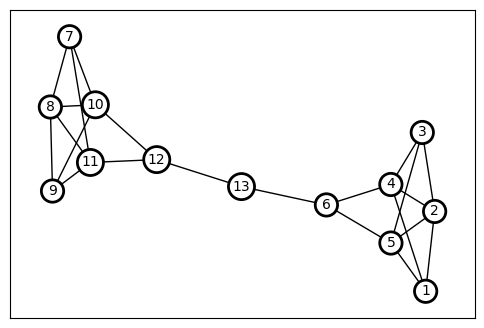

Result via 'greedy':


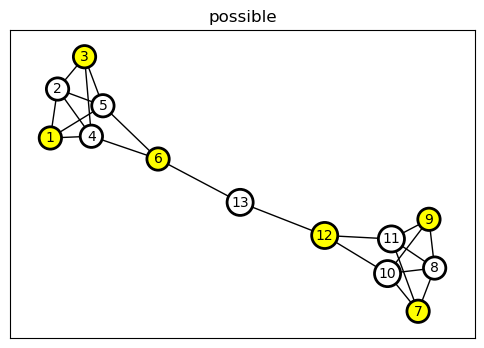

Result via 'backtracking':


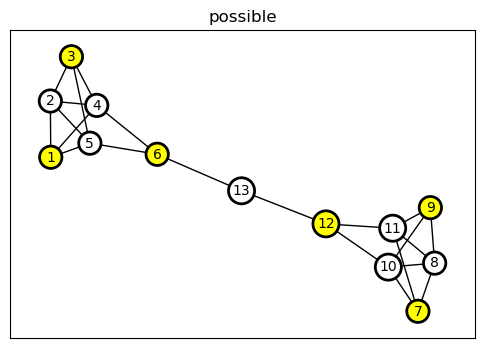

In [29]:
graph = Graph.from_file('samples/extra_7.in')
        
print("Raw Graph:")
graph.draw_graph()
graph.validate_and_show_bins(greedy)
graph.validate_and_show_bins(backtracking)

#### Algorithm testing (non-visualizable)

In [31]:
test_algorithm(greedy, True)

Trying samples/small_6.in

AssertionError: greedy returned 'impossible', while 'possible' was expected

In [ ]:
test_algorithm(backtracking, True)

Trying samples/small_6.in ✅
Trying samples/small_5.in ✅
Trying samples/small_4.in ✅
Trying samples/small_3.in ✅
Trying samples/small_2.in ✅
Trying samples/small_1.in ✅
Trying samples/extra_8.in ✅
Trying samples/extra_7.in ✅
Trying samples/extra_6.in ✅
Trying samples/extra_5.in ✅
Trying samples/extra_4.in ✅
Trying samples/extra_3.in ✅
Trying samples/extra_2.in ✅
Trying samples/extra_1.in ✅
Trying samples/big_5.in ✅
Trying samples/big_3.in ✅
Trying samples/big_2.in ✅
Trying samples/big_1.in ✅

All 18 test cases have been passed by the 'backtracking' algorithm!


In [ ]:
test_algorithm(brute_force, True)

Trying samples/small_6.in ✅
Trying samples/small_5.in

AssertionError: branch_and_bound returned 'possible', while 'impossible' was expected